## 1.데이터 불러오기

In [20]:
from glob import glob
from os.path import isdir
import os
import pandas as pd
abnormal_r=[]
abnormal_l=[]
abnormal_f=[]
abnormal_b=[]
normal=[]

#데이터 경로를 filepath list에 저장
for x in glob('../data/*/*걷기 무게중심_우*'):
    abnormal_r.append(x)
for x in glob('../data/*/*걷기 무게중심_좌*'):
    abnormal_l.append(x)
for x in glob('../data/*/*걷기 무게중심_앞*'):
    abnormal_f.append(x)
for x in glob('../data/*/*걷기 무게중심_뒤*'):
    abnormal_b.append(x)
for x in glob('../data/*/*걷기 무게중심_전*'):
    abnormal_f.append(x)
for x in glob('../data/*/*걷기 무게중심_후*'):
    abnormal_b.append(x)    
for x in glob('../data/*/*걷기_보통*'):
    normal.append(x)

In [25]:
filepath=[normal,abnormal_l,abnormal_r,abnormal_f,abnormal_b]

In [22]:
#import libraries for RNN
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
scale_columns=['x','y','z']
for i in filepath:
    print(len(i))
#len(filepath[0])

10
10
10
10
10


## 2. 데이터 라벨링

In [32]:
li=[]
li.append(0)
li[0]=1


In [44]:
dflist=[]
idx=0
for files in filepath:
    # normal, left, right, front ,back--> 0,1,2,3,4
    temp=pd.DataFrame()
    for file in files:
        data=pd.read_excel(open(file, 'rb'))
        data['label']=idx    
        temp=pd.concat([temp,data[scale_columns+['label']]])
    idx+=1
    dflist.append(temp)

##### number of data for each state (label)

In [49]:
for i in dflist:
    print(len(i))

14019
13990
13989
13978
13987


## 3. train/test split

In [112]:
from sklearn.model_selection import train_test_split
all_df=pd.DataFrame()
for df in dflist:
    all_df=pd.concat([all_df,df])
train_df, test_df =train_test_split(all_df,test_size=0.2,random_state=42,shuffle=True)

In [88]:
print(train_df_origin.shape)
print(test_df_origin.shape)

(55970, 4)
(13993, 4)


In [93]:
train_df

array([[-0.32598954,  0.23880597, -0.07792208,  0.5       ],
       [-0.45294996, -0.70149254,  0.15584416,  1.        ],
       [ 1.7356236 ,  0.47761194,  1.38961039, -1.        ],
       ...,
       [-0.46938013, -0.04477612, -0.28571429,  0.5       ],
       [-0.03061987, -0.82089552, -0.46753247, -1.        ],
       [-0.31404033,  0.8358209 ,  0.27272727, -0.5       ]])

In [113]:
X_train,y_train=train_df[scale_columns],train_df['label']
X_test, y_test = test_df[scale_columns] , test_df['label']

## 4. Scaling 
 fit the scaler only on the training data

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

scaler = scaler.fit(train_df[scale_columns])

train_df.loc[:,scale_columns] = scaler.transform(
  train_df[scale_columns].to_numpy()
)

test_df.loc[:,scale_columns] = scaler.transform(
  test_df[scale_columns].to_numpy()
)

In [116]:
print(train_df.shape)
print(test_df.shape)

(55970, 4)
(13993, 4)


In [110]:
train_df

array([[-0.32598954,  0.23880597, -0.07792208,  0.5       ],
       [-0.45294996, -0.70149254,  0.15584416,  1.        ],
       [ 1.7356236 ,  0.47761194,  1.38961039, -1.        ],
       ...,
       [-0.46938013, -0.04477612, -0.28571429,  0.5       ],
       [-0.03061987, -0.82089552, -0.46753247, -1.        ],
       [-0.31404033,  0.8358209 ,  0.27272727, -0.5       ]])

## 4. Create_dataset for model

In [128]:
from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)


In [129]:

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(
    train_df[scale_columns],
    train_df.label,
    TIME_STEPS,
    STEP
)

X_test, y_test = create_dataset(
    test_df[scale_columns],
    test_df.label,
    TIME_STEPS,
    STEP
)


In [130]:
print(X_train.shape, y_train.shape)

(1395, 200, 3) (1395, 1)


In [131]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

## 5. Create Network

In [132]:
model = keras.Sequential()
model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=128, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

## 6. Model Evaluation

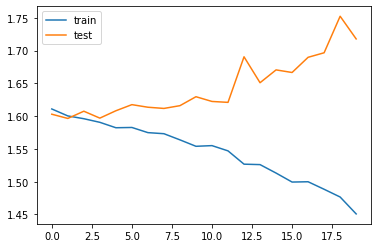

In [137]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
model.evaluate(X_test, y_test)

In [139]:
y_pred = model.predict(X_test)

Train: 0.405, Test: 0.203


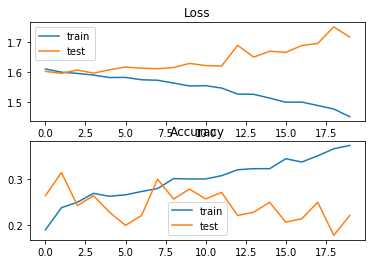

In [147]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test,y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_cm(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(18, 16)) 
    ax = sns.heatmap(
      cm, 
      annot=True, 
      fmt="d", 
      cmap=sns.diverging_palette(220, 20, n=7),
      ax=ax
    )

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

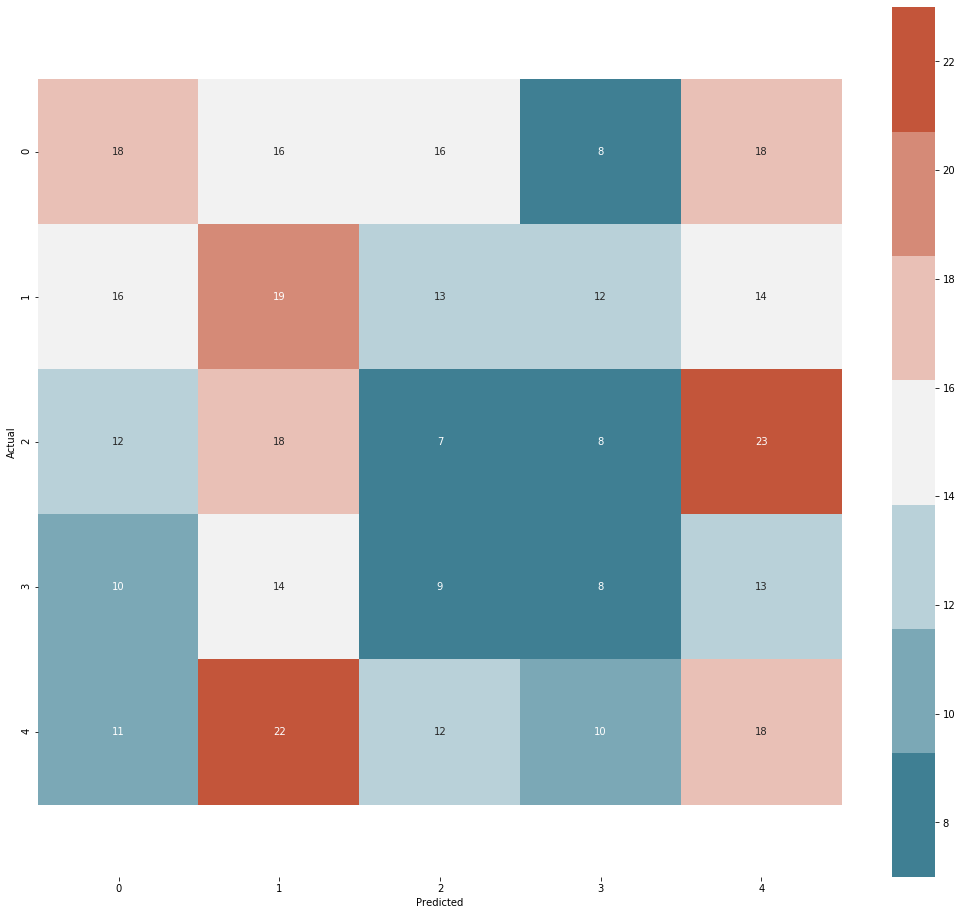

In [143]:
plot_cm(
  enc.inverse_transform(y_test),
  enc.inverse_transform(y_pred),
  enc.categories_[0]
)